In [21]:
import pandas as pd
import numpy as np
import networkx as nx
import torch
import torch.nn as nn
import math, time
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
tqdm.pandas()
%cd /home/jeroen/repos/traffic-scheduling/network/
from generate import generate_grid_network, generate_simple_instance
from automaton import Automaton
from exact import solve

/home/jeroen/repos/traffic-scheduling/network


We can load the train and test data sets from disk. Skip the next computations in sections "Generate training data" and "Compute optimal solutions" when the optimal solutions have already been computed previously.

In [22]:
data = pd.read_pickle('data/data.pkl')
train, test = {}, {}
for i, row in data.iterrows():
    train[i] = pd.read_pickle(f'data/train_{i}.pkl')
    test[i] = pd.read_pickle(f'data/test_{i}.pkl')

# Crossing time scheduling in network of intersections

We analyze the efficiency of constructive (auto-regressive) heuristics for the crossing time scheduling problem in grid networks (like Manhattan) of intersections.

## Generate training data

Generate a small grid network and some instances with a fixed number of arrivals per route. In the next section, we solve these instances to optimality using mixed-integer linear programming, from which we later extract the expert demonstration as observation-action pairs. We use the term observations because it is the result of a static non-parameterized transformation on which the parameterized model is then fitted.

In [6]:
data = pd.DataFrame([
    [5, 2, 1],
    [5, 3, 1],
    [5, 3, 2],
], columns=['n_arrivals', 'grid_m', 'grid_n'])

Generate some grid networks and store it together with the routes.

In [8]:
data[['G', 'routes']] = data.apply(lambda row: generate_grid_network(row['grid_m'], row['grid_n']), axis=1, result_type='expand')
data.to_pickle('data/data.pkl')

For each specification, we generate some training instances and some test instances that will be used in the final optimality evaluation.

In [6]:
N_train, N_test = 500, 100
train, test = {}, {}
for i, row in data.iterrows():
    f = lambda: generate_simple_instance(row['G'], row['routes'], arrivals_per_route=row['n_arrivals'])
    train[i] = pd.DataFrame(zip([f() for _ in range(N_train)]), columns=['instance'])
    test[i] = pd.DataFrame(zip([f() for _ in range(N_test)]), columns=['instance'])

## Compute optimal solutions

We solve each instance in the training and test set to optimality, using a Mixed-Integer Linear Programming (MILP) solver.

In [8]:
timelimit_opt = 60

def solve_instance(x):
    res = solve(x['instance'], timelimit=timelimit_opt)
    return res['y'], res['obj'], res['done'], res['gap'], res['time']

start = time.time()
for i, row in data.iterrows():
    print(f"set {row['n_arrivals']}, grid size {row['grid_m']} x {row['grid_n']}")
    cols = ['opt_y', 'opt_obj', 'opt_done', 'opt_gap', 'opt_time']
    train[i][[*cols]] = train[i].progress_apply(solve_instance, axis=1, result_type='expand')
    test[i][[*cols]] = test[i].progress_apply(solve_instance, axis=1, result_type='expand')

    # save to disk
    train[i].to_pickle(f'data/train_{i}.pkl')
    test[i].to_pickle(f'data/test_{i}.pkl')
print(f'total computation time: {time.time() - start}')

set 5, grid size 2 x 1


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

set 5, grid size 3 x 1


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

set 5, grid size 3 x 2


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

total computation time: 1030.4407222270966


Next, we use the optimal crossing time schedules to backtrack the actions for the automaton that lead to this optimal schedule.

In [9]:
def compute_route_order(row):
    """Compute the order in which vehicles pass each intersection
    based on the order of the route to which the vehicles belong."""
    instance = row['instance']
    schedule = row['opt_y']
    route_order = {}
    indices = schedule.keys() # (r, k, v) tuples
    for v in instance['G'].intersections:
        route_order[v] = sorted(filter(lambda x: x[2] == v, indices), key=lambda i: schedule[i])
        route_order[v] = list(map(lambda x: x[0], route_order[v])) # take route index r
    return [route_order] # to prevent unpacking in DataFrame

for i, row in data.iterrows():
    train[i][['opt_route_order']] = train[i].apply(compute_route_order, axis=1, result_type='expand')
    train[i].to_pickle(f'data/train_{i}.pkl')

## Exhaustive policy

In [26]:
def earliest_route(automaton, v):
    """Get the route with the earliest arrival at intersection v."""
    first_vehicles = { r: automaton.D.nodes[r, k, v]['LB']
                      for r in automaton.routes_at_intersection[v]
                      for k in automaton.order_indices[r] }
    return min(first_vehicles, key=first_vehicles.get)

In [27]:
def threshold_heuristic(instance, threshold=0):
    automaton = Automaton(instance)

    # visit intersections in topological order
    # execute exhaustive policy at intersection v
    G = instance['G']
    for v in nx.topological_sort(G.subgraph(G.intersections)):
        routes = automaton.routes_at_intersection[v].copy()

        # start with the route with the earliest vehicle
        r = earliest_route(automaton, v)
        automaton.step(r, v)
        while v in automaton.pending_intersections:
            # next route candidate
            r_next = routes[(routes.index(r) + 1) % len(routes)]
            
            # next vehicle exists on current route
            if (r, v) in automaton.pending_crossings:
                k = automaton.last_order[r, v]
                # earliest crossing time of next vehicle on this route
                LB_next = automaton.D.nodes[r, k + 1, v]['LB']
                # check threshold condition
                if automaton.D.nodes[r, k, v]['LB'] + instance['rho'] + threshold >= LB_next:
                    # continue on this route
                    automaton.step(r, v)
                    continue
            else:
                routes.remove(r)

            r = r_next
            automaton.step(r, v)

    return automaton.get_obj()

In [28]:
def eval_exhaustive(test, set_id):
    tqdm.pandas(desc=f"{set_id} evaluating")
    return test.progress_apply(lambda x: threshold_heuristic(x['instance'], threshold=0), axis=1).mean()

In [29]:
data['exhaustive_obj'] = data.apply(lambda row: eval_exhaustive(test[row.name], row.name), axis=1)

0 evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

1 evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

2 evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

## GNN heuristic

### Model definition

For the observations of the GNN model, we **copy the whole disjunctive graph** for each state. Alternatively, we could use some sort of masking for non-final states.

In [ ]:
from torch.nn.functional import relu
from torch.nn import Sequential, Linear, ReLU, BatchNorm1d
from torch_geometric.nn import GINConv

class GNNModel(nn.Module):

    def __init__(self):
        super().__init__()
        # we need a separate layer for the first iteration, because the initial
        # feature dimension in different from the node embedding dimension
        lin0 = Sequential(Linear(1, 16), ReLU(), Linear(16, 32), ReLU(), BatchNorm1d(32))
        self.gin0 = GINConv(lin0, train_eps=True)

        lin1 = Sequential(Linear(32, 32), ReLU(), Linear(32, 32), ReLU(), BatchNorm1d(32))
        self.gin1 = GINConv(lin1, train_eps=True)

        lin2 = Sequential(Linear(32, 32), ReLU(), Linear(32, 32), ReLU(), BatchNorm1d(32))
        self.gin2 = GINConv(lin2, train_eps=True)
        
        self.lin1 = Linear(32, 32)
        self.lin2 = Linear(32, 16)
        self.lin3 = Linear(16, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.gin0(x, edge_index)
        x = self.gin1(x, edge_index)
        #x = self.gin2(x, edge_index)

        x = self.lin1(x)
        x = relu(x)
        x = self.lin2(x)
        x = relu(x)
        x = self.lin3(x)

        return x.squeeze()
    
    def state_transform(self, automaton):
        state = automaton.D.copy()
        # remove all edges connecting to or from nodes that are done
        state.remove_done_edges()
        return state

    def  inverse_action_transform(self, automaton, r, v):
        # Instead of (r, v) pairs, which are used in the automaton, we
        # use the full (r, k, v) tuple, like in Zhang et al., where they
        # use the full operation a_t = O_{ij} as action.
        k = automaton.unscheduled[r, v][0]
        return r, k, v

gnn_model = GNNModel()

### Training

Collect all the state-action pairs in a single dataset to support mini-batching via the `DataLoader` class.

In [152]:
from torch_geometric.loader import DataLoader
from torch_geometric.utils.convert import from_networkx
from util import vehicle_indices, route_indices

# force double during conversion
torch.set_default_dtype(torch.float32)

instance = generate_simple_instance(G, routes, arrivals_per_route=A)
automaton = Automaton(instance)
# actions are all vehicle-intersection pairs
valid_gnn_actions = list(automaton.D.nodes)

def generate_graphs(G, routes):
    """Generate a set of graphs based on optimal schedules."""
    graphs = []
    for instance, y in train_data:
        states, actions, _ = collect_state_action_pairs(instance, y, model)
        for state, action in zip(states, actions):        
            graph = from_networkx(state, group_node_attrs=['LB'])
            graph.action = valid_gnn_actions.index(action) # map to integers indices
            graphs.append(graph)
    return graphs

What are the following attributes:

- label
- weight
- batch: index of graph to which this node belongs
- ptr

**Assumption**: node order (see `batch.label`) is the same among all state graphs.

In [ ]:
def stacked_batch(batch, indices):
    """Transform a 'flat batch' of dimension (N*B), where N is number of graphs
    in batch and B is number of nodes per graph, to a 'stacked batch' of
    dimension (N, B), based on batch indices `batch.batch`."""
    unique = torch.unique(indices)
    return torch.vstack([batch[indices == i] for i in unique])

data_train = DataLoader(generate_data(G, routes, N), batch_size=10, shuffle=True)

We now have the following classification task: map disjunctive **graph** to an **action** (route-intersection pair). We use a GIN to compute an embedding for each node, which is fed through an MLP and softmax to produce a probability over nodes. In Zhang et al., each action corresponds to a unique node, encoding the operations that is dispatched next. However, we only really need to provide a route-intersection pair, but **how to exploit this in the policy model**?

The GNN computes node embeddings, which are mapped to a score for each node. We compute the softmax over the scores of the nodes and then compute the negative log likelihood loss for backpropagation.

In [ ]:
from torch.nn.functional import cross_entropy

learning_rate = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 20
print("\ntraining model\n")
model.train()
for i in range(epochs):
    loss_total = 0
    print(f'epoch: {i}')
    for batch in data_train:
        optimizer.zero_grad()
        # compute node scores
        y = model(batch)
        y = y.masked_fill(~batch.action_mask.bool(), -torch.inf) # ignore invalid
        # restack for loss calculation
        pred = stacked_batch(y, batch.batch)
        target = batch.action
        loss = cross_entropy(pred, target)
        loss.backward()
        loss_total += loss
        optimizer.step()
    print(f"loss: {loss_total.item()}")

### Evaluate imitation of GNN policy

In [ ]:
from torch import argmax

def evaluate_imitation(model, N=100):
    """Measure accuracy based on unseen expert demonstration state-action pairs."""
    model.eval()
    print("\ngenerating test data\n")
    data_test = DataLoader(generate_data(G, routes, N))
    total_correct = 0
    print("\nevaluating imitation accuracy\n")
    for batch in tqdm(data_test):
        # compute node scores
        y = model(batch)
        # mask invalid actions (set to -inf)
        y = y.masked_fill(~batch.action_mask.bool(), -torch.inf)
        # restack for loss calculation
        pred = stacked_batch(y, batch.batch)
        pred = argmax(pred, dim=1)
        target = batch.action
        total_correct += pred == target
    print(f"accuracy: {total_correct.item() / len(data_test)}")

In [ ]:
evaluate_imitation(model)

### Evaluate scheduling of GNN policy

Current definition of objective in `exact.py` is total sum of crossing times, including at exit points.

In [ ]:
from torch import masked_select

def evaluate_scheduling(model, N=100):
    """Evaluate average objective when executing the policy over full
    unseen problem instances compared to average optimal objective."""
    print("\nevaluating policy\n")
    model.eval()
    obj_opt = 0
    obj_model = 0
    for _ in trange(N):
        instance = generate_simple_instance(G, routes, arrivals_per_route=A)

        # solve optimally
        y, obj = solve(instance)
        obj_opt += obj

        # TEST objective definition
        # _, actions, _ = collect_state_action_pairs(instance, y)

        # execute learned heuristic
        automaton = Automaton(instance)
        while not automaton.done:
            state = automaton.D
            graph = from_networkx(state, group_node_attrs=['LB'])
            # compute node scores
            y = model(graph)
            # mask invalid actions (set to -inf)
            y = y.masked_fill(~graph.action_mask.bool(), -torch.inf)
            y = argmax(y)
            # translate index back to actual action
            action = valid_gnn_actions[y]
            r, k, v = action
            # execute action on automaton
            automaton.step(r, v)

        # TEST objective definition
        # for action in actions:
        #     r, k, v = action
        #     automaton.step(r, v)

        # compute obj from automaton
        obj_model += automaton.get_obj()

    print(f"obj_opt={obj_opt / N} vs obj_model={obj_model / N}")
    print(f"approximation ratio={obj_model / obj_opt}")

In [ ]:
evaluate_scheduling(model)

## RNN heuristics

### Extract expert demonstration

The observations for the RNN model are the collection of _horizons_ for each route-intersection pair and flags that indicate which route was served during the last step of the automaton. We truncate the horizons and store them in reverse order, as required by the RNN embedding.

In [8]:
def state_transform(automaton, max_horizon=5):
    # compute minimum LB across all unscheduled nodes in disjunctive graph
    LBs = []
    for _, data in automaton.D.nodes(data=True):
        if not data['done']:
            LBs.append(data['LB'])
    min_LB = min(LBs)

    n_crossings = len(automaton.crossing_indices)

    # flag: crossing done
    done = torch.zeros((n_crossings, 1))
    # flag: last scheduled route at intersection (0 before first action)
    last = torch.zeros((n_crossings, 1))
    # (truncated) horizon
    length = torch.zeros((n_crossings, 1))
    obs = torch.zeros((n_crossings, max_horizon))

    for i, (r, v) in enumerate(automaton.crossing_indices):
        done[i] = (r, v) not in automaton.pending_crossings
        if automaton.last_route[v] is not None:
            last[i] = int(automaton.last_route[v] == r)
            
        horizon_length = min(len(automaton.unscheduled[r, v]), max_horizon)
        length[i] = horizon_length
        if horizon_length > 0:
            full_horizon = [automaton.D.nodes[r, k, v]['LB'] for k in automaton.unscheduled[r, v]]
            # subtract minimal LB and truncate to max_horizon in reverse order
            obs[i, :horizon_length] = torch.tensor(list(reversed(full_horizon[:horizon_length]))) - min_LB

    # first bool is "done flag", second bool is "last route flag",
    # third number indicates length of the horizon, rest is padded horizon
    return torch.hstack([done, last, length, obs])

Backtrack state-action pairs from optimal schedules. We could also say "observation"-action pairs, because the above static transformation is applied. Note that the global order of actions is not unique: the order in which intersections are considered does not matter for the final schedule. Therefore, we can pick any or multiple sequences of intersections and replay the corresponding sequence of actions on the automaton to generate the corresponding sequence of observation-action pairs that act as the expert demonstration. More precisely, we use the single action lookahead strategy to generate state-actions pairs. At every state, we store for each intersection the local route index for the route in the optimal local order. The function `intersection_order` determines at which intersection the action is actually taken to move to the next state.

In [47]:
def extract_state_action_pairs(instance, opt_route_order, intersection_order):
    """Backtrack observations and actions for the optimal schedule."""
    states, actions = [], []
    # deep copy of route_order with reversed lists to use as stacks
    route_order = { v: list(reversed(opt_route_order[v])) for v in opt_route_order }
    automaton = Automaton(instance)
    while not automaton.done:
        states.append(state_transform(automaton))

        # add all valid action indices: index of next local route at each intersection
        action = torch.full([len(automaton.G.intersections)], -1) # -1 is "ignore_index"
        for v in automaton.pending_intersections:
            r = route_order[v][-1]
            r_index = automaton.routes_at_intersection[v].index(r)
            action[automaton.G.intersections.index(v)] = r_index
        actions.append(action)

        # pick a single action that is actually executed
        v = intersection_order(automaton)
        r = route_order[v].pop()
        automaton.step(r, v)

    return states, actions

We define some fixed procedures to visit intersection during the state-action generation.

1. Randomly pick some pending intersection to visit next.
2. Keep visiting the same intersection until it is done, then move to the next. When state-action trajectories are visualized in a grid, these ones appear on the "boundary" of this state-action grid.
3. Alternate between intersection to keep the number of scheduled vehicles balanced among them. These appear near the "diagonal" of the state-action grid.

In [43]:
from random import choice

def alternate_intersection_order(automaton):
    if automaton.last_intersection in automaton.pending_intersections and len(automaton.pending_intersections) >= 2:
        # visit next intersection
        i = automaton.pending_intersections.index(automaton.last_intersection)
        return automaton.pending_intersections[(i + 1) % len(automaton.pending_intersections)]
    else:
        return automaton.pending_intersections[0]

intersection_orders = {
    'random': lambda automaton: choice(automaton.pending_intersections),
    'boundary': lambda automaton: automaton.pending_intersections[0],
    'alternate': alternate_intersection_order,
}

Collect all the state-action pairs for the training instances, using different sampling strategies. We store the tuple of (states, actions) as an object in a pandas DataFrame cell for convenient access.

In [56]:
states_actions = pd.DataFrame(dtype=object, columns=intersection_orders.keys())
for set_id in data.index:
    for order_name, order in intersection_orders.items():
        states, actions = [], []
        for _, row in tqdm(train[set_id].iterrows(), desc=f"extracting {set_id} {order_name}", total=train[set_id].shape[0]):
            ss, aa = extract_state_action_pairs(row['instance'], row['opt_route_order'], order)
            states.extend(ss), actions.extend(aa)
        states_actions.at[set_id, order_name] = (states, actions)

states_actions.to_pickle(f'data/states_actions.pkl')

extracting 0 random:   0%|          | 0/500 [00:00<?, ?it/s]

extracting 0 boundary:   0%|          | 0/500 [00:00<?, ?it/s]

extracting 0 alternate:   0%|          | 0/500 [00:00<?, ?it/s]

extracting 1 random:   0%|          | 0/500 [00:00<?, ?it/s]

extracting 1 boundary:   0%|          | 0/500 [00:00<?, ?it/s]

extracting 1 alternate:   0%|          | 0/500 [00:00<?, ?it/s]

extracting 2 random:   0%|          | 0/500 [00:00<?, ?it/s]

extracting 2 boundary:   0%|          | 0/500 [00:00<?, ?it/s]

extracting 2 alternate:   0%|          | 0/500 [00:00<?, ?it/s]

As a sanity check, we replay the actions for a single instance in the 'boundary' order and verify whether we end up with the same objective.

In [57]:
set_id = 0

# actions were stored sorted, so the first few belong to the first training instance
row = train[set_id].iloc[0] # first training instance
_, actions = states_actions['boundary'][set_id]
actions = iter(actions)

# replay actions
automaton = Automaton(row['instance'])
while not automaton.done:
    action = next(actions)
    v = automaton.pending_intersections[0] # 'boundary'
    ri = action[automaton.G.intersections.index(v)]
    r = automaton.routes_at_intersection[v][ri]
    automaton.step(r, v)

opt_y = row['opt_y'] # check with optimal schedule
for node, LB in automaton.D.nodes.data('LB'):
    assert math.isclose(LB, opt_y[node]), "crossing times do not match"

assert automaton.done, "automaton not done"
assert math.isclose(row['opt_obj'], automaton.get_obj()), "final objectives do not match"

Load stored expert demonstration from disk.

In [855]:
states_actions = pd.read_pickle(f'data/states_actions.pkl')

### Model definition

In [58]:
def packed_last_items(pack, lengths):
    """Obtain the last item for each sequence in a batch of packed sequences `pack`."""
    # see: https://discuss.pytorch.org/t/get-each-sequences-last-item-from-packed-sequence/41118/7
    sum_batch_sizes = torch.cat((
        torch.zeros(2, dtype=torch.int64),
        torch.cumsum(pack.batch_sizes, 0)
    ))
    sorted_lengths = lengths[pack.sorted_indices.cpu()]
    last_seq_idxs = sum_batch_sizes[sorted_lengths] + torch.arange(lengths.size(0))
    last_seq_items = pack.data[last_seq_idxs]
    last_seq_items = last_seq_items[pack.unsorted_indices]
    return last_seq_items

In [59]:
from torch.nn.utils.rnn import pack_padded_sequence

class RnnGridModel(nn.Module):
    def __init__(self, n_intersections):
        super().__init__()
        self.n_intersections = n_intersections
        self.n_crossings = 2 * n_intersections
        
        self.d1 = self.n_intersections  # number of labels to predict
        self.C = 2                      # number of classes

        self.rnn_out = 16
        self.rnns = nn.ModuleList([
            nn.RNN(1, self.rnn_out, batch_first=True) for _ in range(self.n_crossings)
        ])
        self.network = nn.Sequential(
            nn.Linear(self.n_crossings * (2 + self.rnn_out), 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, self.n_crossings),
        )

    @property
    def device(self):
        return next(self.parameters()).device

    def forward(self, obs):
        batch_size = obs.size()[0]
        rnn_embeds = []

        if batch_size == 1: # single batch processing (use for faster non-parallelized evaluation)
            for c in range(self.n_crossings):
                length = int(obs[0, c, 2].item())
                if length == 0:
                    rnn_embeds.append(torch.zeros((1, self.rnn_out)))
                else:
                    horizon = obs[0, c, 3:3+length]
                    out, _ = self.rnns[c](horizon.unsqueeze(1)) # add dimension as required by RNN
                    rnn_embeds.append(out[-1].unsqueeze(0))
        
        else: # batch processing (use while training)
            for c in range(self.n_crossings):
                lengths = obs[:, c, 2].cpu().int()
                seq = obs[:, c, 3:].unsqueeze(-1)
                # clamp lengths to 1 to deal with empty sequences (as suggested at https://github.com/pytorch/pytorch/issues/4582#issuecomment-589905631)
                packed = pack_padded_sequence(seq, lengths.clamp(min=1), batch_first=True, enforce_sorted=False)
                out, _ = self.rnns[c](packed)
                # get hidden output at last t for each sequence
                last_seq_items = packed_last_items(out, lengths)
                # set outputs zero for empty sequences (as suggested at https://github.com/pytorch/pytorch/issues/4582#issuecomment-589905631)
                last_seq_items.masked_fill_((lengths == 0).view(-1, 1).to(self.device), 0)
                rnn_embeds.append(last_seq_items)

        # stack at dimension of crossings
        rnn_embed = torch.stack(rnn_embeds, dim=1)
        embedding = torch.cat([obs[:, :, 0:2], rnn_embed], dim=2)
        embedding = torch.flatten(embedding, 1, 2)

        out = self.network(embedding)
        return torch.reshape(out, (batch_size, self.d1, self.C))

    def action_transform(self, automaton, out, v):
        batch_size = out.size()[0]
        assert batch_size == 1, "Currently supports only single batches."

        # get intersection index
        vi = automaton.G.intersections.index(v)
        out = out[0, vi, :]

        # mask crossings that are done
        for r in automaton.routes_at_intersection[v]:
            if (r, v) not in automaton.pending_crossings:
                ri = automaton.routes_at_intersection[v].index(r)
                out[ri] = -torch.inf

        ri = torch.argmax(out) # greedy inference
        # translate index back to actual action
        r = automaton.routes_at_intersection[v][ri]
        return r, v

    def heuristic(self, automaton, v):
        s = state_transform(automaton).unsqueeze(0).to(self.device)
        return self.action_transform(automaton, self.forward(s), v)

### Training and reporting

In [60]:
from torch.utils.data import TensorDataset, DataLoader
from torch.nn.functional import cross_entropy

neural_train_losses = []

total_steps = 3000  # = total number of batches

def train_rnn(train, model, set_id):    
    # load expert demonstration data onto CPU/GPU
    states, actions = states_actions['alternate'][set_id]
    states = torch.stack(states).to(model.device)
    actions = torch.stack(actions).to(model.device)

    batch_size = 40
    train_set = TensorDataset(states, actions)    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

    learning_rate = 1e-4
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    with tqdm(total=total_steps, desc=f"{set_id} training", leave=False) as pbar:
        step = 0
        model.train()
        while True:
            for s, a in train_loader:
                optimizer.zero_grad()
                # model outputs (N, d1, C), but cross_entropy() expects (N, C, d1)
                out = model(s).transpose(1, 2)
                loss = cross_entropy(out, a, ignore_index=-1)
                loss.backward()
                optimizer.step()
                train_losses.append(loss.item())

                step += 1
                pbar.update(1)

                if step >= total_steps: break # ...out of inner loop
            if step >= total_steps: break # ...out of outer loop

    neural_train_losses.append(train_losses)

    return model

In [61]:
def eval_rnn(train, test, set_id):
    n_intersections = data['grid_n'][set_id] * data['grid_m'][set_id]
    model = RnnGridModel(n_intersections).cpu()
    model = train_rnn(train, model, set_id)
    model.eval().cpu() # avoid passing data back-and-forth between cpu and gpu

    def eval_scheduling(row):
        automaton = Automaton(row['instance'])
        while not automaton.done:       
            v = intersection_orders['alternate'](automaton)
            automaton.step(*model.heuristic(automaton, v))
        return automaton.get_obj()

    tqdm.pandas(desc=f"{set_id} evaluating")
    return test.progress_apply(eval_scheduling, axis=1, result_type='expand').mean()

In [62]:
for set_id in [0, 1, 2]:
    data.loc[set_id, 'rnn_obj'] = eval_rnn(train[set_id], test[set_id], set_id)

0 training:   0%|          | 0/3000 [00:00<?, ?it/s]

0 evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

1 training:   0%|          | 0/3000 [00:00<?, ?it/s]

1 evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

2 training:   0%|          | 0/3000 [00:00<?, ?it/s]

2 evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

In [63]:
# take mean objective and running time over all test instances
data['opt_obj'] = data.apply(lambda row: test[row.name]['opt_obj'].mean(), axis=1)
data['opt_time'] = data.apply(lambda row: test[row.name]['opt_time'].mean(), axis=1)

# compute (relative) approximation ratio
data['rnn_gap'] = data.apply(lambda row: row['rnn_obj'] / row['opt_obj'], axis=1)
data['exhaustive_gap'] = data.apply(lambda row: row['exhaustive_obj'] / row['opt_obj'], axis=1)

In [64]:
data[['n_arrivals', 'grid_m', 'grid_n', 'exhaustive_gap', 'rnn_gap']]

,n_arrivals,grid_m,grid_n,exhaustive_gap,rnn_gap
0,5,2,1,1.114453,1.011592
1,5,3,1,1.154376,1.017044
2,5,3,2,1.183186,1.022486


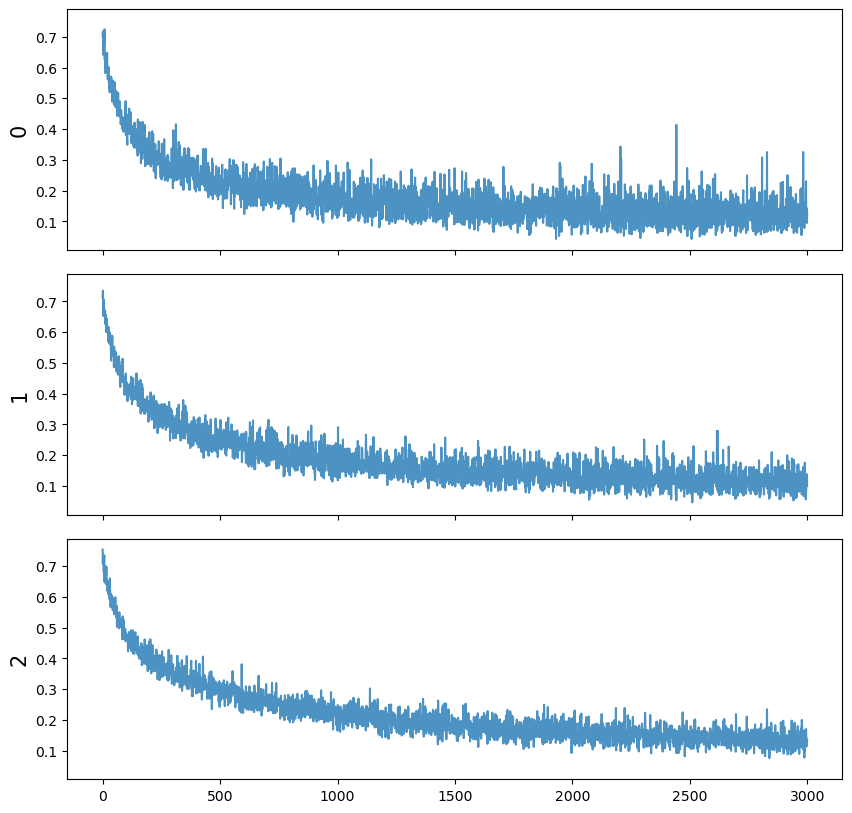

In [65]:
fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(nrows=len(neural_train_losses), ncols=1, hspace=0.1, wspace=0.1)
axes = gs.subplots(sharex=True, sharey=True)

for ax, train_losses in zip(axes.T.flatten(), neural_train_losses):
    ax.plot(train_losses, alpha=0.8, label='training')
    
for ax, label in zip(axes, ['0', '1', '2']):
    ax.set_ylabel(label, size=15)

plt.savefig(f'neural_fit.pdf')
plt.show()